# Analysis, Goals, and Predictions

Here, I'd like to go over the loss functions being used to train the models and what we are aiming for, so that we can better understand the models' performance as training progresses. My approach will follow that of Ng (2015), as outlined in the textbook __"Deep Learning" by Goodfellow et al.__:

* Determine your goals -- error metric(s) and target (re: desired) value(s). 
* Establish a working end-to-end pipeline. 
* Determine bottlenecks in performance, their sources, and whether they're due to overfitting/underfitting/software defect(s). 
* Repeatedly make incremental changes such as gathering new data, adjusting hyperparams, or changing algorithms. 

## Selecting Hyperparameters

#### Manual HyperParameter Tuning

Here are I'll just bullet the main ideas:
* The learning rate is perhaps the most important hyperparameter. The training error increases appx exponentially as the learning rate decreases below its optimal value. Above the optimal value, the training error basically shoots off to infinity (vertical wall). 
* Next, the best perfomance usually comes from a large model that is regularized well, for example, by using dropout. 
* Table showing typical hyperparameter relationships with model capacity. Remember that you can basically brute force your way to good performance by jacking up the model capacity and training set size. 

| Hyperparameter | Increases capacity when... | 
| -------------- | -------------------------- |
| Num hidden units | increased | 
| Learning rate | tuned optimally |
| Convolution kernal width | increased | 
| Implicit zero padding | increased | 
| Weight decay coefficient | decreased | 
| Dropout rate | decreased | 


#### Automatic HyperParameter Optimization

__Grid Search__: This is what I'm doing right now. User selects a small finite set of values to explore. Grid search trains a model for every joint specification of hyperparameter values in the Cartesian product of possible values. The experiment with the best _validation error_ is chosen as the best. 

__Random Search (Better)__: 
1. Define a marginal distribution for each hyperparameter, e.g. multinoulli for discrete hparams or uniform (log-scale) for positive real-valued hyparams. For example, if we were interested in the range $[10^{-5}, 0.1]$ for the learning rate:
$$
\begin{align}
\texttt{logLearningRate} &\sim Unif[-1, -5] \\
\texttt{learningRate} &= 10^{logLearningRate}
\end{align}
$$

## Debugging Strategies

Determining whether or not a machine learning model is broken is hard. Here are some debugging tips:
* __Visualize the model in action__: Not just the quantitative stuff. How do the filters look? How is the chatbot responding?
* __Visualize the worst mistakes__: For example, our chatbot models output probabilities for the word tokens, and we either sample or argmax. One way to get an idea of what sentences our model does poorly on is to choose examples where the output probability max is *small*. In other words, if argmax(output) is much lower than usual, that says our model is rather unsure what is the best next word (think of the limiting case where it outputs 1/numOutputs for all possible tokens!). 
* __Fit a tiny dataset__: Oooh, I like this one! Even small models can be guaranteed to be able to fit a sufficiently small dataset. Make sure you can write program that can train on say, a handful of input-output sentences, and produce the output given any of the inputs with near perfect accuracy. 
* __Monitor histograms of activations/gradients__: The preactivation can tell us if the units saturate, or how often they do. For tanh units, the average of the absolute value of the preactivations tells us how saturated the unit is. It is also useful to compare the parameter gradients with the parameters themselves. Ideally, we'd like the gradients over a minibatch to be about 1 percent of the magnitude of the parameter. 

## Plotting the Hyperparameter-Search Results

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 8
BASE = '/home/brandon/Documents/seq2seq_projects/data/saved_train_data/'

In [9]:
path = BASE + 'cornell_03_11.csv'
df = pd.read_csv(path, index_col=0)
df.head()

,embed_size,global_step,learning_rate,loss,state_size,vocab_size
0,56,2,0.189885,9.211146,380,10000
0,56,203,0.189885,5.385020,380,10000
0,56,404,0.189885,5.219425,380,10000
0,56,605,0.189885,4.849638,380,10000
0,56,806,0.189885,4.682628,380,10000


In [34]:
embed_sizes = set(df['embed_size'])
state_sizes = set(df['state_size'])
learning_rates = set(df['learning_rate'])
print(embed_sizes)
print(state_sizes)
print(learning_rates)

def get_split(df, col, vals):
    return [(v, df[df[col]==v]) for v in vals]

def split_df_and_plot(df, split_col, split_vals):
    """
    Example usage:
        split_df_and_plot(df, 'learning_rate', learning_rates)
    """
    df_split = get_split(df, split_col, split_vals)
    plt.figure(figsize=(8, 6))
    for val, df_sp in df_split:
        ax=plt.subplot()
        plt.scatter(df_sp['global_step'], df_sp['loss'], label='%.3f' % val)

    plt.title(split_col + ' Comparisons', fontsize=20)
    ax.set_xlabel('Global Step', fontsize=15)
    ax.set_ylabel('Validation Loss', fontsize=15)
    leg = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
               title=split_col, prop={'size':15})
    plt.setp(leg.get_title(),fontsize=20)
    plt.tight_layout()
    plt.savefig(split_col+'.pdf', bbox_extra_artists=(leg,), bbox_inches='tight')
    plt.show()
    
def inception_split(df, split_col_one, split_vals_one, split_col_two, split_vals_two):
    """ENHANCE"""
    df_split_one = get_split(df, split_col_one, split_vals_one)
    fig = plt.figure(figsize=(12, 10))
    ctr = 1
    for val_one, df_sp_one in df_split_one:
        df_split_two = get_split(df_sp_one, split_col_two, split_vals_two)
        ax=fig.add_subplot(3, 2, ctr)
        for val_two, df_sp_two in df_split_two:
            ax.scatter(df_sp_two['global_step'], df_sp_two['loss'], label=split_col_two + ': %.2f' % val_two)
            ax.set_ylim([3., 10.])
            plt.title(split_col_one + ' = %.2f' % val_one, fontsize=15)
            ax.set_xlabel('Global Step', fontsize=12)
            ax.set_ylabel('Validation Loss', fontsize=12)
            if ctr in [2, 4, 6]:
                leg = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
                       title=split_col_two, prop={'size':12})
                plt.setp(leg.get_title(),fontsize=15)
        ctr += 1
    plt.tight_layout()
    plt.savefig(split_col_one + "_" + split_col_two + '.pdf', bbox_extra_artists=(leg,), bbox_inches='tight')
    plt.show()

{32}
{128}
{0.5}


#### Single Plots Distinguishing One Variable

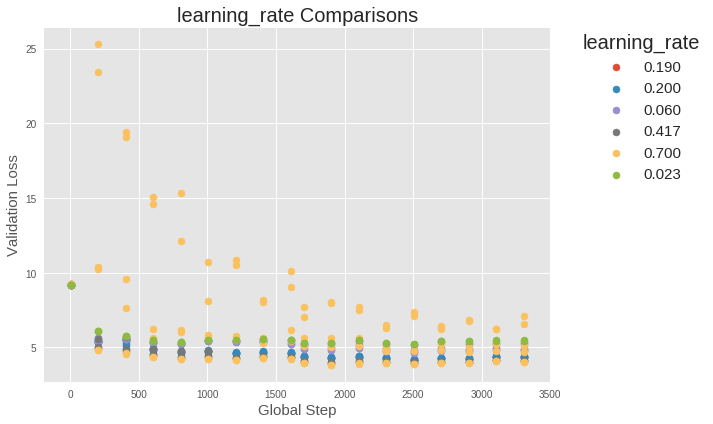

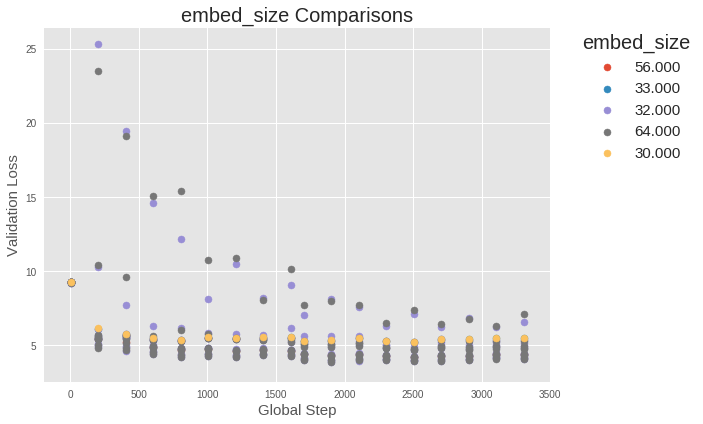

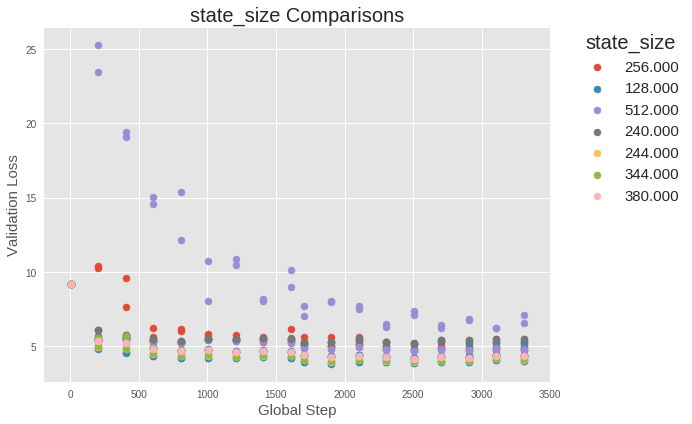

In [16]:
split_df_and_plot(df, 'learning_rate', learning_rates)
split_df_and_plot(df, 'embed_size', embed_sizes)
split_df_and_plot(df, 'state_size', state_sizes)

#### Plots with Fixed Learning Rate

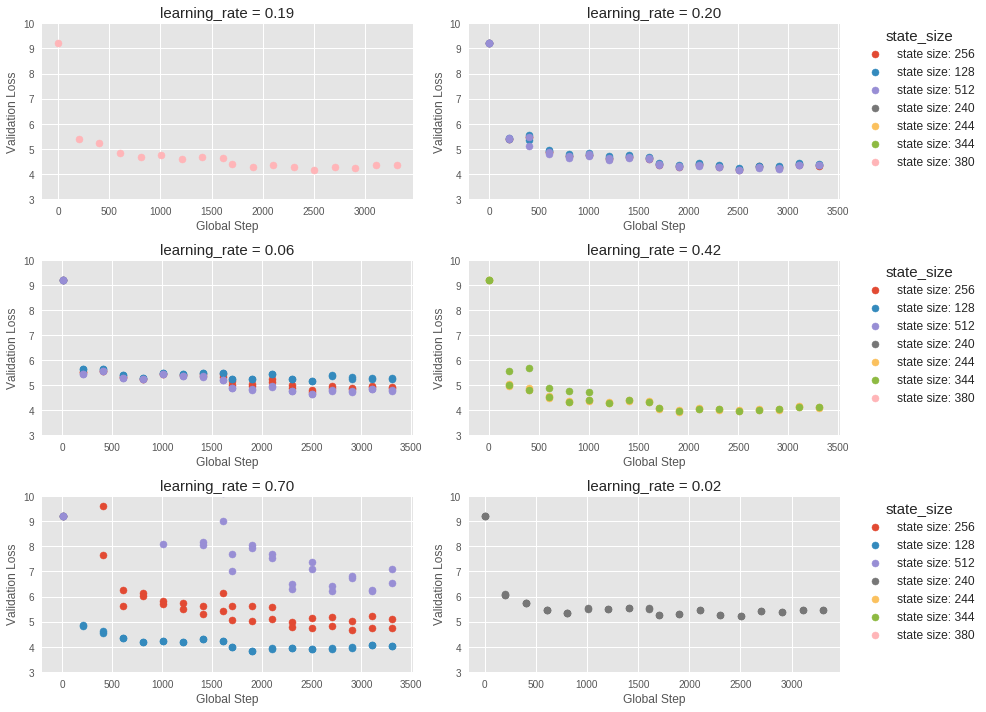

In [24]:
inception_split(df, "learning_rate", learning_rates, "state_size", state_sizes)

## Hyperparam Search on Dropout and Num Layers

In [26]:
path = BASE + 'cornell.csv'
df = pd.read_csv(path, index_col=0)
df.head()

,dropout_prob,embed_size,global_step,learning_rate,loss,num_layers,state_size,vocab_size
0,0.2,32,2,0.5,10.595644,2,128,40000
0,0.2,32,203,0.5,5.747638,2,128,40000
0,0.2,32,404,0.5,5.864061,2,128,40000
0,0.2,32,605,0.5,5.508001,2,128,40000
0,0.2,32,806,0.5,5.496625,2,128,40000


In [27]:
dropout_probs = set(df['dropout_prob'])
num_layers = set(df['num_layers'])
print(dropout_probs)
print(num_layers)

{0.20000000000000001, 0.5, 0.80000000000000004}
{2, 4}


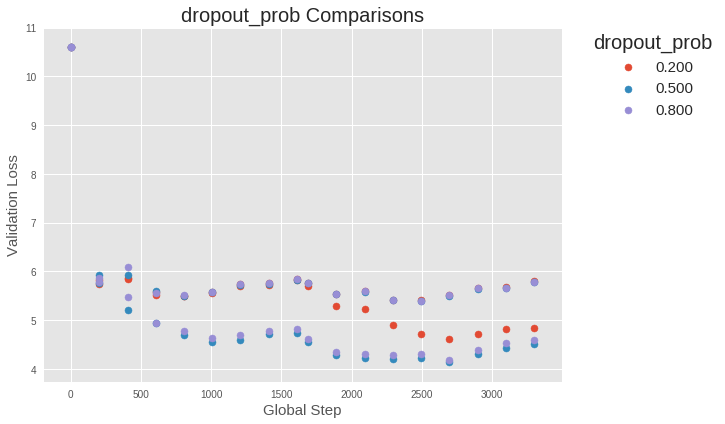

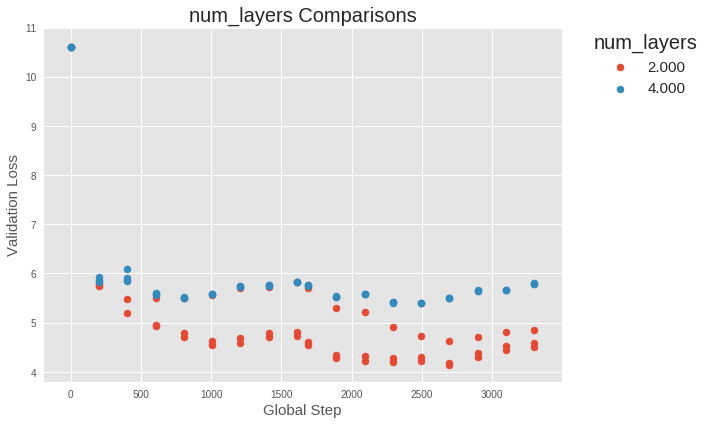

In [28]:
split_df_and_plot(df, 'dropout_prob', dropout_probs)
split_df_and_plot(df, 'num_layers', num_layers)

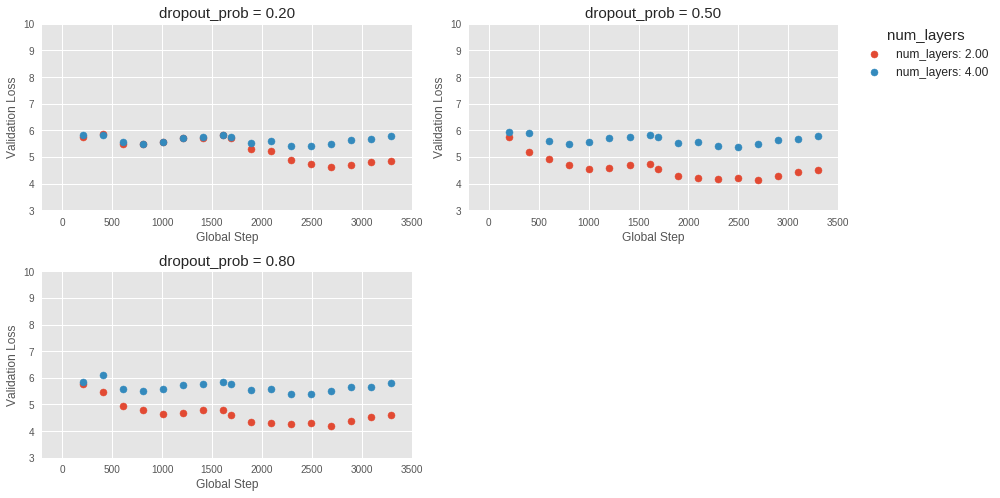

In [35]:
inception_split(df, "dropout_prob", dropout_probs, "num_layers", num_layers)

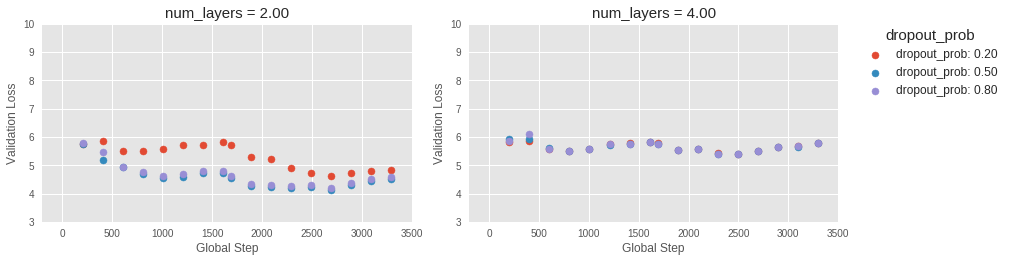

In [36]:
inception_split(df, "num_layers", num_layers, "dropout_prob", dropout_probs)

# Loss Functions

I've been scratching my head a lot lately thinking about how to implement sampled softmax loss without having to split tensors across time, an operation that destroys any gain in runtime efficiency offered by negative sampling. Let's start by working through how tensorflow samples classes by default: __log-uniform (Zipfian) base distribution__:

$$
\text{Prob(c)} = \dfrac{\log(c+2) - \log(c + 1)}{\log(\text{vocab size} + 1)}
$$

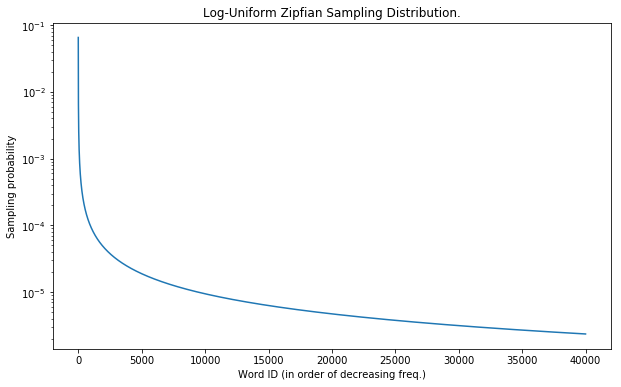

In [14]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
vocab_size = 40000
x_axis = np.arange(vocab_size)
zipfian = (np.log(x_axis + 2) - np.log(x_axis + 1)) / np.log(vocab_size + 1)
plt.figure(figsize=(10, 6))
plt.semilogy(x_axis, zipfian)
plt.title('Log-Uniform Zipfian Sampling Distribution.')
plt.xlabel('Word ID (in order of decreasing freq.)')
plt.ylabel('Sampling probability')
plt.show()

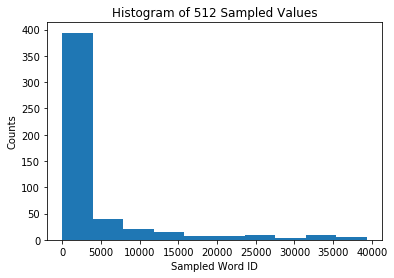

In [15]:
batch_size = 64
num_samples = 512
samples = [np.random.choice(x_axis, p=zipfian) for _ in range(num_samples)]
plt.hist(samples)
plt.title('Histogram of %d Sampled Values' % num_samples)
plt.xlabel('Sampled Word ID')
plt.ylabel('Counts')
plt.show()

### Candidate Sampling - TensorFlow

[[Link]](https://www.tensorflow.org/extras/candidate_sampling.pdf)

#### What is Candidate Sampling

__Goal__: Learn a compatibility function $F(x, y)$ which says something about the compatibility of a class $y$ with a context $x$. 

__Candidate sampling__: for each training example $(x_i, y_i^{\text{true}})$, only need to evaluate $F(x, y)$ *for a small set of classes* $\{C_i\} \subset \{L\}$, where $\{L\}$ is the set of all possible classes (vocab size number of elements). 

We represent $F(x, y)$ as a *layer that is trained by back-prop from/within the loss function*.

### From Scratch: tf.nn.sampled_softmax_loss

My version of tensorflow's op, customized with DynamicBot in mind. 

Here is a subset of the source code with all the irrelevant parts removed, with the aim of understanding the implementation.

```python
def sampled_softmax_loss(output_projection, labels, state_outputs, num_sampled, vocab_size, sess=None):
    """
    Args:
        output_projection: (tuple) returned by any Decoder.get_projections_tensors()
            - output_projection[0] == w tensor. [state_size, vocab_size]
            - output_projection[1] == b tensor. [vocab_size]
        labels: 2D Integer tensor. [batch_size, None]
        state_outputs: 3D float Tensor [batch_size, None, state_size].
            - In this project, usually is the decoder batch output sequence (NOT projected).
            - N.B.: Assumption is that 'None' here is always the same 'None' in labels (target sequence length).
        num_sampled: number of classes out of vocab_size possible to use.
        vocab_size: total number of classes.
    """
```

First step: unpack output projection tuple and reshape for convenience. 
* Possible optimization: Don't do reshapes. They seem to be slow for sparse stuff. 
* SparseTensors may be useful here. Look into later. 

```python
    # Extract transpose weights, now shape is [vocab_size, state_size].
    # Use tf.reshape which is dynamic as opposed to static (i.e. slow) tf.transpose.
    weights = tf.reshape(output_projection[0], [vocab_size, -1])
    state_size = tf.shape(weights)[-1]
    biases  = output_projection[1]
```

__Shape check__:
* weights: [vocab size, state size]
* biases: [vocab size]

Next, enter our implementation of what tensorflow has named as ```_compute_sampled_logits```. 
* The values passed in ```name_scope``` are for graph visualization reasons. Not important.

```python

    with tf.name_scope("compute_sampled_logits", [weights, biases, state_outputs, labels]):
        # Smush tensors so we can use them with tensorflow methods.
        # Question: Docs suggest we should reshape to [-1, 1] so I'm keeping.
        # but original code had it as just [-1].
        labels = tf.cast(labels, tf.int64)
        labels_flat = tf.reshape(labels, [-1, 1])
```

__Sampling__:  Returns 3-tuple:
1. sampled_candidates: [num_sampled] tensor
2. true_expected_count shape = [batch_size $\times$ None, 1] tensor
    * Entries associated 1-to-1 with smushed labels.
3. sampled_expected_count shape = [num_sampled] tensor
    * Entries associated 1-to-1 with sampled_candidates.
    
```python
        # Sample the negative labels.
        sampled_values = tf.nn.log_uniform_candidate_sampler(
            true_classes=labels_flat, num_true=1, num_sampled=num_sampled,
            unique=True, range_max=vocab_size)
        S_i, Q_true, Q_samp = (tf.stop_gradient(s) for s in sampled_values)
```

__What's going on here__: 
* NOTE: Remember we are inside a single time slice/step right now!!!
* ```S_i```: (int64) tensor of shape [num samples], using naming convention of article. The subset of the vocabulary we'll be using henceforth for *all examples in the current batch*. 
* ```Q_true```: (float) tensor of shape [batch size, 1]. The probability of sampling the true class. Period. Literally the value $Q(y \mid x)$ for each training example out of ```batch_size``` total. 
* ```Q_samp```: (float) tensor of shape [num samples]. The value of $Q(y_{samp} \mid \text{log uniform})$ for all $y_{samp}$ in the tensor ```sampled```. That's it. *Independent of, and not associated with, batch size*. 

__Epiphany__: Just realized something. The reason we should *not* do the suggestion from stackoverlow is because for a given sampled sentence, *it would force all sampled words in that sentence to be from the same subset of size num samples*. We would get pretty terrible sentences, especially when the next word is likely to be rare given the previous word. 

```python

        # Casting this back to actually be flat.
        batch_times_none = tf.shape(labels_flat)[0]
        labels_flat = tf.reshape(labels, [-1])
        # Get concatenated 1D tensor of shape [batch_size * None + num_samples],
        C_i = tf.concat([labels_flat, S_i], 0)

        # The embedding_lookup here should be thought of as embedding
        # the integer label and sampled IDs in the state space.
        # all_w has shape [batch_size * None + num_samples, state_size]
        # all_b has shape [batch_size * None + num_samples]
        all_w       = tf.nn.embedding_lookup(weights, C_i, partition_strategy='div')
        all_b       = tf.nn.embedding_lookup(biases, C_i)
        
        true_w      = tf.slice(all_w, begin=[0, 0], size=[batch_times_none, state_size])
        true_b      = tf.slice(all_b, begin=[0], size=[batch_times_none])
        
        sampled_w   = tf.slice(all_w, begin=[batch_times_none, 0], size=[num_sampled, state_size])
        sampled_b   = tf.slice(all_b, begin=[batch_times_none], size=[num_sampled])

        state_outputs    = tf.reshape(state_outputs, [batch_times_none, state_size])
        state_outputs = tf.cast(state_outputs, tf.float32)
        
        true_logits      = tf.reduce_sum(tf.multiply(state_outputs, true_w), 1)
        true_logits     += true_b - tf.log(Q_true)
```

Question: how are we not done here? 
* Answer 1: because we haven't softmaxed yet...
* Answer 2: Ohhhhhhh. It's because true logits only gives us the log probabilities *for the target ys*. It's important to remember we are basically building a smaller network output over num samples (+1) space instead of vocab space. So far, we just have the +1 part. Now we need the num samples part. And yes, technically the num samples argument should clarify that it ends up using num samples +1.

I see now that remove accidental hits defaults to True because it's probably easier than dealing with 

```python
        # Matmul shapes [batch_times_none, state_size] * [state_size, num_sampled].
        sampled_logits   = tf.matmul(state_outputs, sampled_w, transpose_b=True) + sampled_b
        # NO. BOO.
        #sampled_logits  += _sparse_to_dense(sampled_logits, tf.expand_dims(labels_flat, -1), sampled, num_sampled) 
        sampled_logits  -= tf.log(Q_samp)

        # Construct output logits and labels. The true labels/logits start at col 0.
        # shape(out_logits) == [batch_times_none, 1 + num_sampled]. I'M SURE.
        out_logits = tf.concat([true_logits, sampled_logits], 1)
        # true_logits is a float tensor, ones_like(true_logits) is a float tensor of ones.
        out_labels = tf.concat([tf.ones_like(true_logits), tf.zeros_like(sampled_logits)], 1)

    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=out_labels, logits=out_logits))
```